# Projet de Reporting - Million Playlist Dataset

Membres du groupe :
- Hugo HOUNTONDJI
- LO Maty
- HU Angel
- PASINI Georgio


## Pre-traitement et nettoyage

#### Nettoyage des données

Ce script a pour objectif de :
Charger les fichiers de données brutes (JSON du MPD).
Aplatir la structure pour avoir une ligne par piste de playlist.
Nettoyer les données (gestion des valeurs nulles, des doublons, conversion des types).
Sauvegarder le jeu de données propre dans un fichier CSV (`alcrowd_cleaned.csv`) qui servira de base pour toutes les analyses futures.


In [49]:
# Importation des bibliothèques
import pandas as pd
import os
import glob
import json

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

print("Nous débutons par l'importation des bibliothèques")


Nous débutons par l'importation des bibliothèques


In [50]:
#################################################################################################

# Chargement et fusion des données
# Nous avons du adapter l'importation des données pour le notebook
base_dir = os.getcwd()
alcrowd_path = os.path.join(base_dir, 'alcrowd')
output_dir = alcrowd_path
os.makedirs(output_dir, exist_ok=True)

#################################################################################################

# Chargement des fichiers JSON
json_files = glob.glob(os.path.join(alcrowd_path, 'mpd.slice.*.json'))
all_playlists = []

if len(json_files) > 0:
    for file in json_files:
        with open(file, 'r') as f:
            data = json.load(f)
            all_playlists.extend(data['playlists'])
    print(f"Chargement de {len(all_playlists)} playlists")
else:
    # Tentative de chargement depuis les données déjà nettoyées pour démonstration
    existing_cleaned_file = os.path.join(alcrowd_path, 'alcrowd_cleaned.csv')
    
    if os.path.exists(existing_cleaned_file):
        print("Fichier de données nettoyées existant trouvé.")
        
        # Charger le fichier existant
        df_existing = pd.read_csv(existing_cleaned_file)
        print(f"Données existantes chargées : {df_existing.shape[0]} lignes et {df_existing.shape[1]} colonnes")
        
        # Reconstituer une structure similaire aux playlists JSON
        sample_playlists = min(1000, df_existing['pid'].nunique())
        unique_pids = df_existing['pid'].unique()[:sample_playlists]
        
        for pid in unique_pids:
            playlist_data = df_existing[df_existing['pid'] == pid]
            if len(playlist_data) > 0:
                first_row = playlist_data.iloc[0]
                
                # Création d'un dictionnaire pour stocker les informations de la playlist
                playlist_info = {
                    'pid': int(pid),  # Identifiant de la playlist
                    'name': first_row['name'],  # Nom de la playlist
                    'num_tracks': int(first_row['num_tracks']),  # Nombre de pistes dans la playlist
                    'num_albums': int(first_row['num_albums']),  # Nombre d'albums dans la playlist
                    'num_artists': int(first_row['num_artists']),  # Nombre d'artistes dans la playlist
                    'num_followers': int(first_row['num_followers']),  # Nombre d'abonnés de la playlist
                    'modified_at': 1500000000,  # Date de dernière modification
                    'tracks': []  # Liste des pistes dans la playlist
                }
                
                # Itération sur chaque piste de la playlist pour extraire les informations
                for _, track in playlist_data.iterrows():
                    # Création d'un dictionnaire pour stocker les informations de la piste
                    track_info = {
                        'artist_name': track['artist_name'],  # Nom de l'artiste
                        'track_name': track['track_name'],  # Nom de la piste
                        'album_name': track['album_name'],  # Nom de l'album
                        'track_uri': track.get('track_uri', f'spotify:track:demo_{track.name}'),  # URI de la piste ou une valeur par défaut
                        'duration_ms': int(track.get('track_duration_ms', 200000)),  # Durée de la piste en millisecondes ou une valeur par défaut
                        'pos': int(track.get('pos', 0))  # Position de la piste dans la playlist ou une valeur par défaut
                    }
                    # Ajout de la piste à la liste des pistes de la playlist
                    playlist_info['tracks'].append(track_info)
                
                # Ajout de la playlist à la liste de toutes les playlists
                all_playlists.append(playlist_info)
        
        print(f"Simulation créée avec {len(all_playlists)} playlists")
        
    else:
        print("Aucun fichier JSON trouvé.")
        print("Veuillez télécharger le Million Playlist Dataset.")
        all_playlists = []

print(f"Chargement de {len(all_playlists)} playlists")


Fichier de données nettoyées existant trouvé.
Données existantes chargées : 67503 lignes et 13 colonnes
Simulation créée avec 1000 playlists
Chargement de 1000 playlists


In [51]:
#################################################################################################

# Aplatissement des données
# l'objevctif de l'aplatissement est de créer un DataFrame avec une ligne par piste de playlist
if all_playlists:
    mpd_df = pd.DataFrame(all_playlists)
    
    # Explosion de la colonne 'tracks' pour créer une ligne par piste
    mpd_exploded_df = mpd_df.explode('tracks')
    tracks_df = mpd_exploded_df['tracks'].apply(pd.Series)
    mpd_flat_df = pd.concat([mpd_exploded_df.drop(columns=['tracks']), tracks_df], axis=1)
    
    # Renommons les colonnes pour éviter les conflits
    if 'duration_ms' in mpd_flat_df.columns:
        cols = mpd_flat_df.columns.tolist()
        idx_playlist_duration = cols.index('duration_ms')
        cols[idx_playlist_duration] = 'playlist_duration_ms'
        if 'duration_ms' in cols[idx_playlist_duration + 1:]:
            idx_track_duration = cols.index('duration_ms', idx_playlist_duration + 1)
            cols[idx_track_duration] = 'track_duration_ms'
        mpd_flat_df.columns = cols
    
    
    df = mpd_flat_df.copy()
    print("Dimensions initiales :", df.shape)

else:
    raise ValueError("Aucune playlist n'a été chargée. Vérifiez les fichiers JSON.")


Dimensions initiales : (67503, 13)


In [52]:
# Nettoyage des données
print("A présent nettoyons nos données")

#################################################################################################

# Gestion des valeurs manquantes
# Dans un premier temps voyons si nous avons des valeurs manquantes (dans la colonne 'track_uri')
print(f"Nombre de lignes avant suppression des valeurs manquantes ('track_uri'): {len(df)}")
df.dropna(subset=['track_uri'], inplace=True)
print(f"Nombre de lignes après suppression des valeurs manquantes ('track_uri'): {len(df)}")

# Suppression de la colonne 'description'
# Nous n'avons pas besoin de cette colonne pour nos analyses
if 'description' in df.columns:
    df.drop(columns=['description'], inplace=True)
    print("Colonne 'description' supprimée.")

# Le '0' peut apparaître si une colonne 'tracks' était vide.
if '0' in df.columns and df['0'].isnull().all():
    df.drop(columns=['0'], inplace=True)

#################################################################################################

# Gestion des doublons
print(f"Nombre de lignes avant suppression des doublons : {len(df)}")
df.drop_duplicates(inplace=True)
print(f"Nombre de lignes après suppression des doublons : {len(df)}")

#################################################################################################

# Conversion des types de données
# Nous convertissons la colonne 'modified_at' en datetime
# Telle quelle la colonne 'modified_at' est en secondes pour faciliter la manipulation nous
# avons fait le choix de la convertir en datetime
df['modified_at'] = pd.to_datetime(df['modified_at'], unit='s')
print("Conversion du type de 'modified_at' en datetime.")
print("Dimensions finales après nettoyage :", df.shape)


A présent nettoyons nos données
Nombre de lignes avant suppression des valeurs manquantes ('track_uri'): 67503
Nombre de lignes après suppression des valeurs manquantes ('track_uri'): 67503
Nombre de lignes avant suppression des doublons : 67503
Nombre de lignes après suppression des doublons : 67503
Conversion du type de 'modified_at' en datetime.
Dimensions finales après nettoyage : (67503, 13)


In [53]:
# Pour finir cette étape de nettoyage des données, nous allons sauvegarder
# les données nettoyées dans un fichier CSV
# Sauvegarde des données nettoyées
print("Sauvegardons les des données nettoyées...")

if not df.empty:
    print("Sauvegarde en cours...")
    
    # Chemin de sauvegarde
    cleaned_data_path = os.path.join(output_dir, 'alcrowd_cleaned.csv')
    
    # nous avons fait le choix d'inclure une gestion des erreurs au cas où
    # Sauvegarde avec gestion d'erreurs
    try:
        df.to_csv(cleaned_data_path, index=False, encoding='utf-8')
        file_size = os.path.getsize(cleaned_data_path) / (1024*1024)  # Taille en MB
        print(f"Données sauvegardées avec succès !")
        print(f"Fichier : '{cleaned_data_path}'")
        print(f"Taille : {file_size:.1f} MB")
        
        # Vérification de la sauvegarde
        verification_df = pd.read_csv(cleaned_data_path, nrows=5)
        print(f"Vérification : {len(verification_df)} lignes testées")
        
    except Exception as e:
        print(f"Erreur lors de la sauvegarde : {e}")
    
    # Rapport final détaillé
    print(f"Résumé des données nettoyées :")
    print(f"   • Nombre total de lignes (tracks) : {len(df):,}")
    print(f"   • Nombre de colonnes : {df.shape[1]}")
    
    if 'pid' in df.columns:
        unique_playlists = df['pid'].nunique()
        avg_tracks_per_playlist = len(df) / unique_playlists
        print(f" Playlists uniques : {unique_playlists:,}")
        print(f" Moyenne tracks/playlist : {avg_tracks_per_playlist:.1f}")
    
    if 'artist_name' in df.columns:
        unique_artists = df['artist_name'].nunique()
        print(f"   • Artistes uniques : {unique_artists:,}")
        
        # Top 5 artistes
        top_artists = df['artist_name'].value_counts().head(5)
        print("   • Top 5 artistes :")
        for artist, count in top_artists.items():
            print(f"     - {artist}: {count:,} tracks")
    
    if 'album_name' in df.columns:
        unique_albums = df['album_name'].nunique()
        print(f"   • Albums uniques : {unique_albums:,}")
    
    if 'track_name' in df.columns:
        unique_tracks = df['track_name'].nunique()
        print(f"   • Tracks uniques : {unique_tracks:,}")
    
    if 'track_duration_minutes' in df.columns:
        min_duration = df['track_duration_minutes'].min()
        max_duration = df['track_duration_minutes'].max()
        avg_duration = df['track_duration_minutes'].mean()
        print(f"   • Durée tracks - Min: {min_duration:.1f}min, Max: {max_duration:.1f}min, Moyenne: {avg_duration:.1f}min")
    
    if 'modified_at' in df.columns and df['modified_at'].notna().any():
        date_range = f"{df['modified_at'].min().strftime('%Y-%m-%d')} à {df['modified_at'].max().strftime('%Y-%m-%d')}"
        print(f"   • Période des données : {date_range}")
    
    print(f"\nQualité des données :")
    missing_percentage = (df.isnull().sum().sum() / (len(df) * len(df.columns))) * 100
    print(f"   • Valeurs manquantes : {missing_percentage:.2f}%")
    print(f"   • Données complètes : {100-missing_percentage:.2f}%")
    
else:
    print("Aucune donnée à sauvegarder")
    print("Le processus ne peut pas continuer sans données")


Sauvegardons les des données nettoyées...
Sauvegarde en cours...
Données sauvegardées avec succès !
Fichier : 'd:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\autre_projet\Reporting-Projet-Annuel\alcrowd\alcrowd_cleaned.csv'
Taille : 9.1 MB
Vérification : 5 lignes testées
Résumé des données nettoyées :
   • Nombre total de lignes (tracks) : 67,503
   • Nombre de colonnes : 13
 Playlists uniques : 1,000
 Moyenne tracks/playlist : 67.5
   • Artistes uniques : 9,722
   • Top 5 artistes :
     - Drake: 939 tracks
     - Kanye West: 415 tracks
     - Kendrick Lamar: 385 tracks
     - Rihanna: 350 tracks
     - Eminem: 332 tracks
   • Albums uniques : 17,437
   • Tracks uniques : 30,049
   • Période des données : 2017-07-14 à 2017-07-14

Qualité des données :
   • Valeurs manquantes : 0.00%
   • Données complètes : 100.00%


## Analyse exploratoire

Ce script a pour objectif de réaliser une analyse exploratoire sur les données nettoyées :
- Charger le jeu de données nettoyé (`alcrowd_cleaned.csv`).
- Réaliser une analyse univariée pour comprendre la distribution de chaque variable (statistiques descriptives, histogrammes).
- Réaliser une analyse bivariée pour explorer les relations entre les variables (matrice de corrélation).
Charger le jeu de données nettoyé (`alcrowd_cleaned.csv`).
Réaliser une analyse univariée pour comprendre la distribution de chaque variable (statistiques descriptives, histogrammes).
Réaliser une analyse bivariée pour explorer les relations entre les variables (matrice de corrélation).


In [54]:
# Configuration pour l'analyse exploratoire
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [55]:
print("Passons à présent à l'analyse exploratoire")

#################################################################################################

# Chargement des données
base_dir = os.getcwd()
data_path = os.path.join(base_dir, 'alcrowd', 'alcrowd_cleaned.csv')

# Création d'un dossier de sortie dédié pour nos graphiques
output_dir = os.path.join(base_dir, 'alcrowd', 'analyse_exploratoire_plots')
os.makedirs(output_dir, exist_ok=True)

if not os.path.exists(data_path):
    raise FileNotFoundError(f"Le fichier de données nettoyées n'a pas été trouvé : {data_path}\n"
                            "Pensez à dans un premier temps, exécuter le script de nettoyage des données.")

df = pd.read_csv(data_path)
print(f"Données chargées depuis '{data_path}'.")


Passons à présent à l'analyse exploratoire
Données chargées depuis 'd:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\autre_projet\Reporting-Projet-Annuel\alcrowd\alcrowd_cleaned.csv'.


In [56]:
# Inspection des données
print("\nInformation sur le DataFrame :")
print(f"Dimensions : {df.shape}")
print(f"Colonnes disponibles : {list(df.columns)}")
print(f"Types de données :")
print(df.dtypes)


Information sur le DataFrame :
Dimensions : (67503, 13)
Colonnes disponibles : ['pid', 'name', 'num_tracks', 'num_albums', 'num_artists', 'num_followers', 'modified_at', 'artist_name', 'track_name', 'album_name', 'track_uri', 'playlist_duration_ms', 'pos']
Types de données :
pid                      int64
name                    object
num_tracks               int64
num_albums               int64
num_artists              int64
num_followers            int64
modified_at             object
artist_name             object
track_name              object
album_name              object
track_uri               object
playlist_duration_ms     int64
pos                      int64
dtype: object


#### Analyse univariée

In [57]:
# Analyse Exploratoire (EDA)
print("\nDébut de l'analyse exploratoire.")

# Analyse univariée
# Débutons en créant quelques statistiques descriptives
print("\nStatistiques descriptives des colonnes numériques :")
print(df.describe())


Début de l'analyse exploratoire.

Statistiques descriptives des colonnes numériques :
                pid    num_tracks    num_albums   num_artists  num_followers  \
count  67503.000000  67503.000000  67503.000000  67503.000000   67503.000000   
mean     508.371317    112.276447     81.050887     59.663985       3.006829   
std      286.288365     63.771477     49.287440     37.390374      35.920805   
min        0.000000      5.000000      2.000000      3.000000       1.000000   
25%      262.000000     57.000000     40.500000     31.000000       1.000000   
50%      505.000000    104.000000     73.000000     53.000000       1.000000   
75%      752.000000    159.000000    115.000000     80.000000       2.000000   
max      999.000000    245.000000    225.000000    175.000000    1038.000000   

       playlist_duration_ms           pos  
count               67503.0  67503.000000  
mean               200000.0     55.638223  
std                     0.0     49.051327  
min             

Graphiques des distributions univariées sauvegardés : d:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\autre_projet\Reporting-Projet-Annuel\alcrowd\analyse_exploratoire_plots\univar_1_distributions_numeriques.png


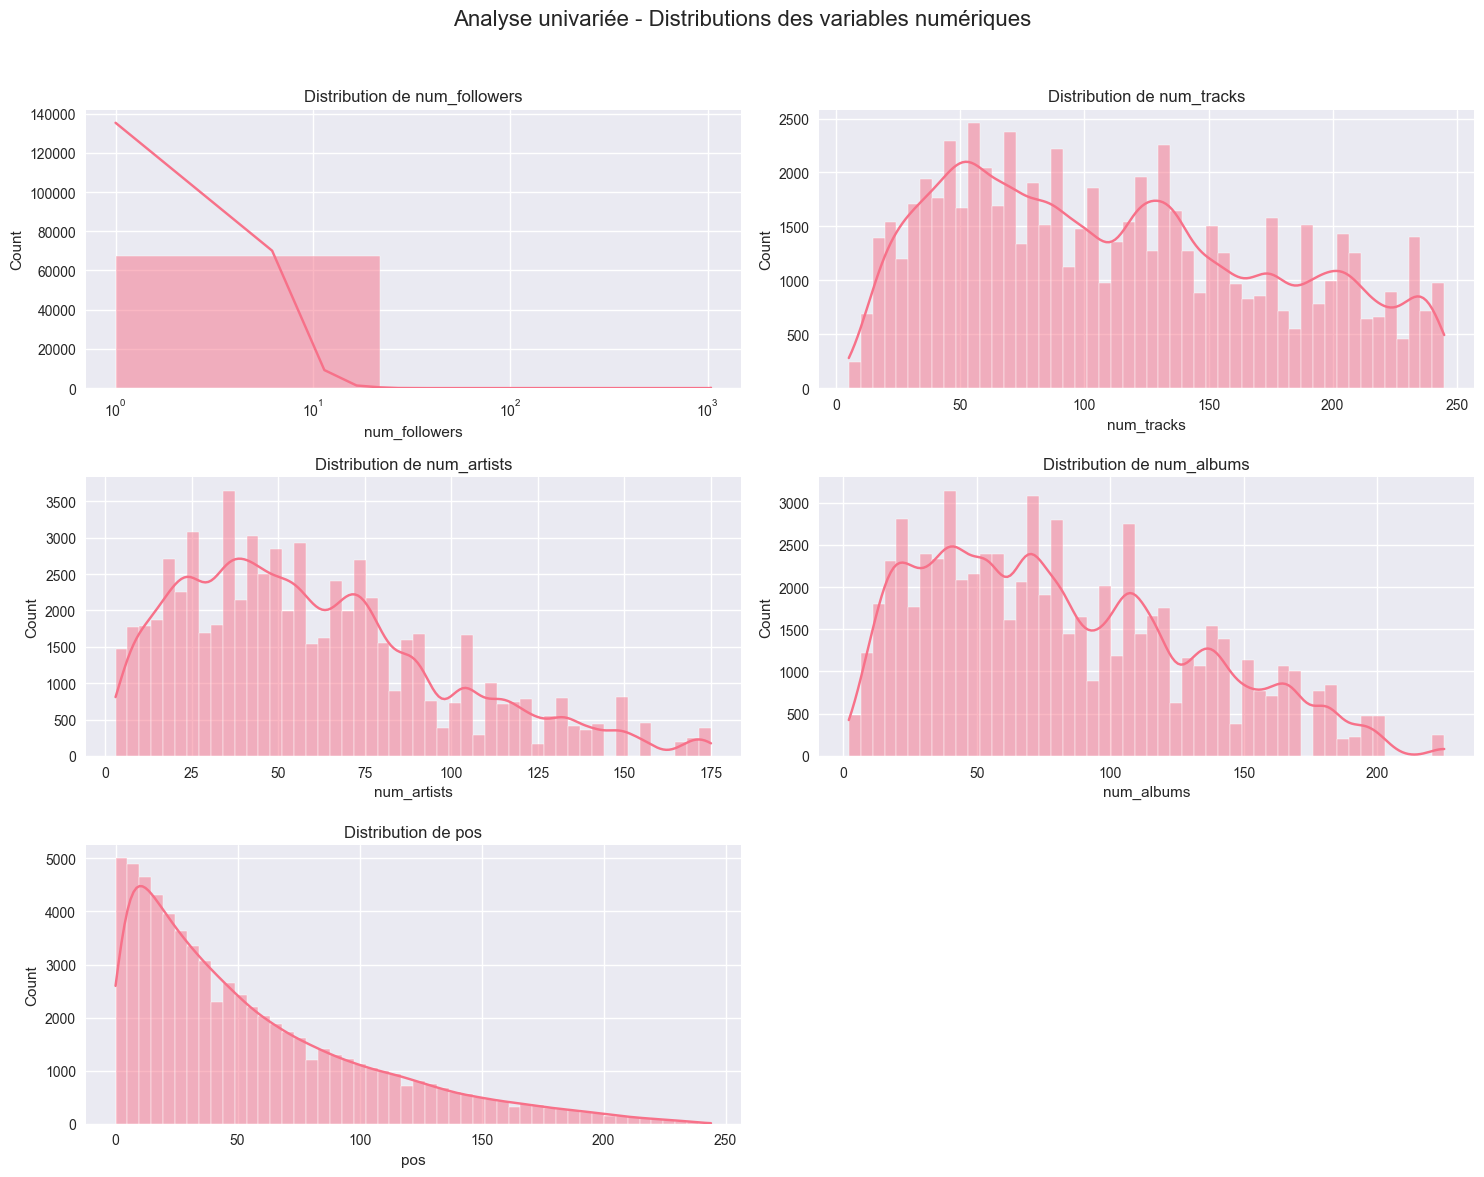

In [58]:
# Visualisation des distributions
numeric_cols_to_plot = ['num_followers', 'num_tracks', 'num_artists', 'num_albums', 'pos']
plt.figure(figsize=(15, 12))
plt.suptitle('Analyse univariée - Distributions des variables numériques', fontsize=16)
for i, col in enumerate(numeric_cols_to_plot, 1):
    plt.subplot(3, 2, i)
    sns.histplot(df[col], kde=True, bins=50)
    plt.title(f'Distribution de {col}')
    # L'échelle log est utile pour les données très asymétriques
    if df[col].max() > 1000 and df[col].min() >= 0:
        plt.xscale('log')
plt.tight_layout(rect=[0, 0, 1, 0.96])
univariate_plot_path = os.path.join(output_dir, 'univar_1_distributions_numeriques.png')
plt.savefig(univariate_plot_path)
print(f"Graphiques des distributions univariées sauvegardés : {univariate_plot_path}")
plt.show()

Boxplots sauvegardés : 'd:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\autre_projet\Reporting-Projet-Annuel\alcrowd\analyse_exploratoire_plots\univar_2_boxplots_numeriques.png'


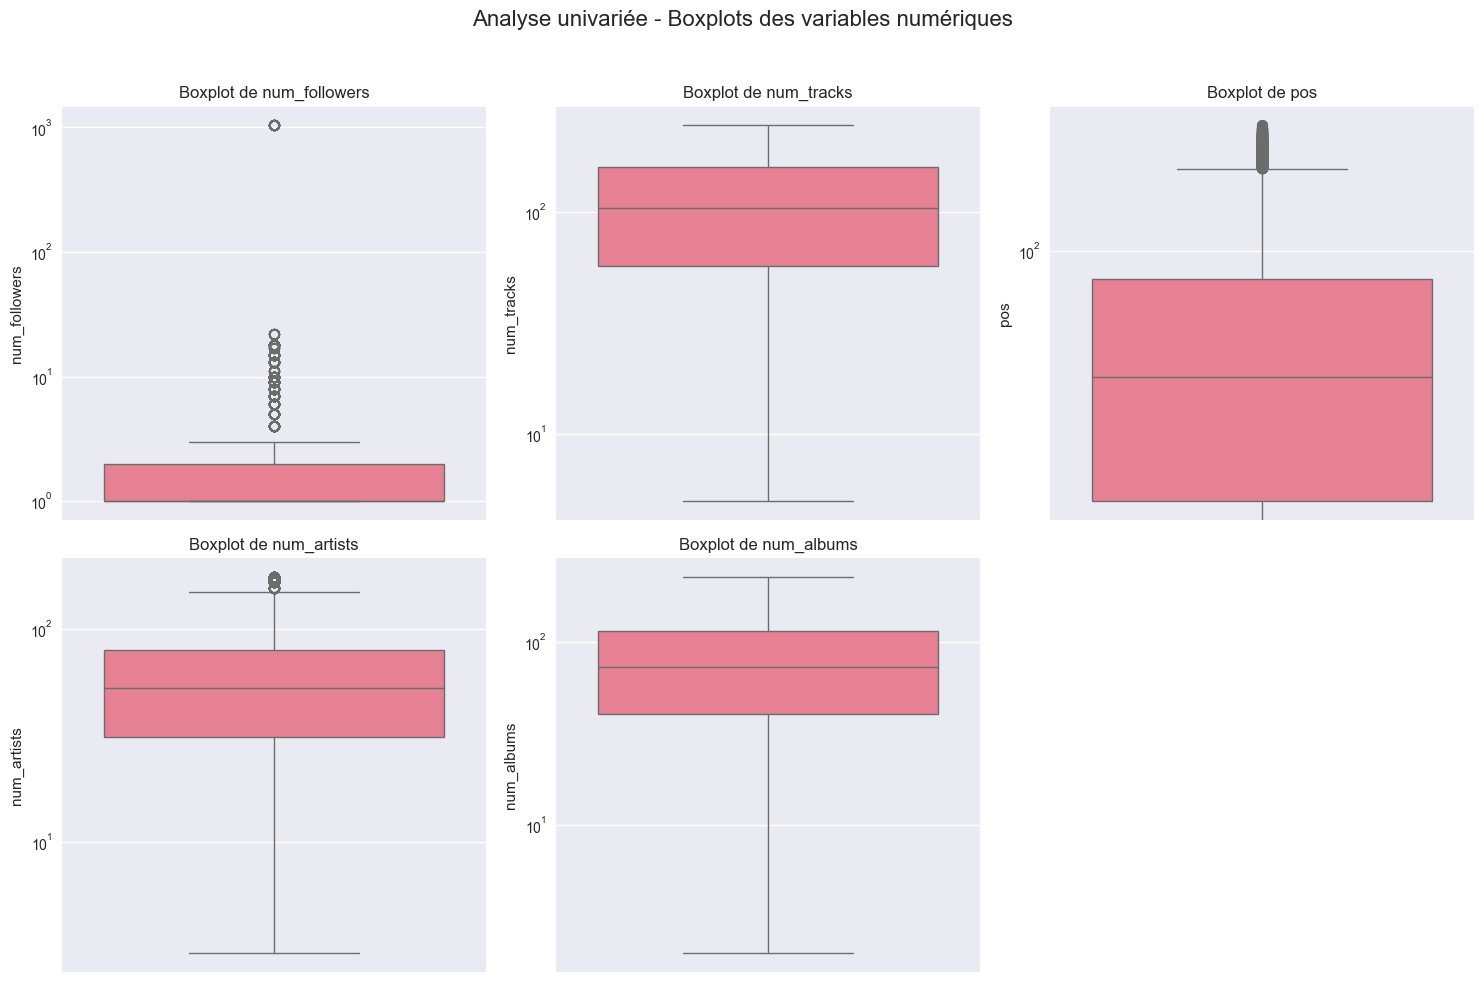

In [59]:
# Boxplots pour les variables numériques
numeric_cols_to_plot = ['num_followers', 'num_tracks', 'pos', 'num_artists', 'num_albums']
plt.figure(figsize=(15, 10))
plt.suptitle('Analyse univariée - Boxplots des variables numériques', fontsize=16)
for i, col in enumerate(numeric_cols_to_plot, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot de {col}')
    plt.yscale('log')
plt.tight_layout(rect=[0, 0, 1, 0.96])
univariate_box_path = os.path.join(output_dir, 'univar_2_boxplots_numeriques.png')
plt.savefig(univariate_box_path)
print(f"Boxplots sauvegardés : '{univariate_box_path}'")
plt.show()

Graphique 'Top 20 des artistes les plus fréquents' sauvegardé : 'd:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\autre_projet\Reporting-Projet-Annuel\alcrowd\analyse_exploratoire_plots\univar_3_top20_artistes.png'


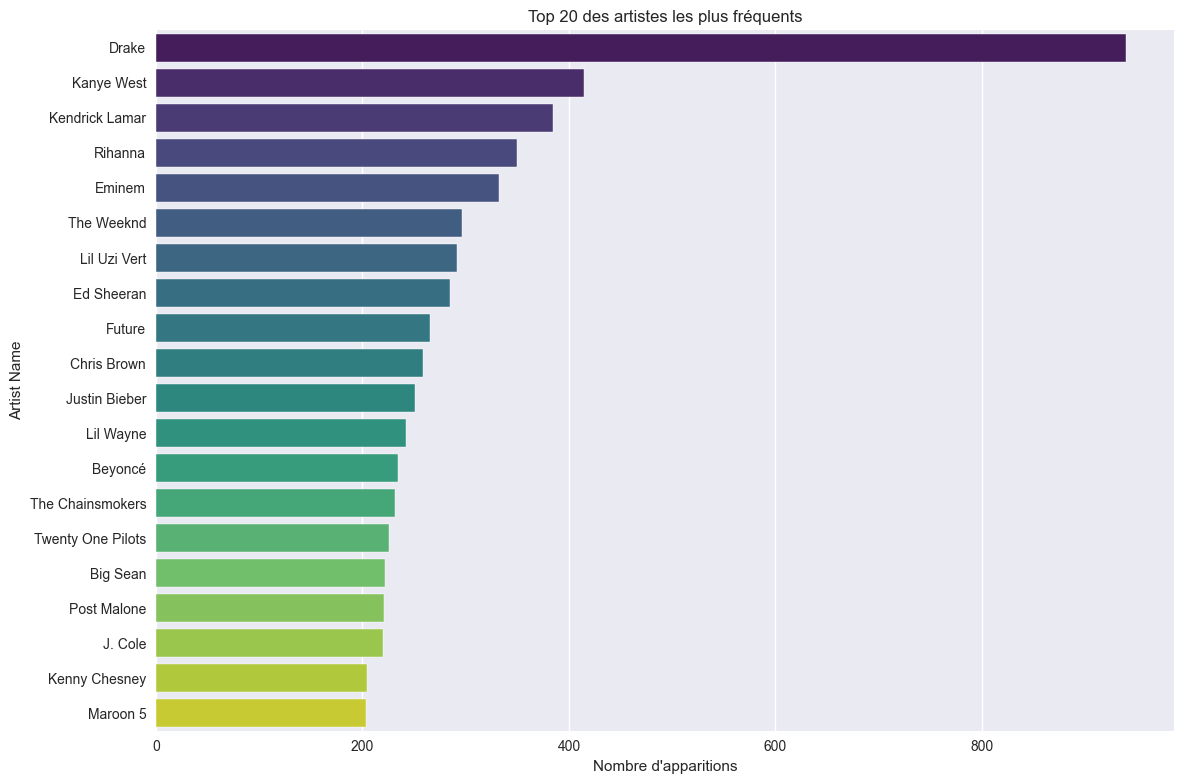

Graphique 'Top 20 des albums les plus fréquents' sauvegardé : 'd:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\autre_projet\Reporting-Projet-Annuel\alcrowd\analyse_exploratoire_plots\univar_4_top20_albums.png'


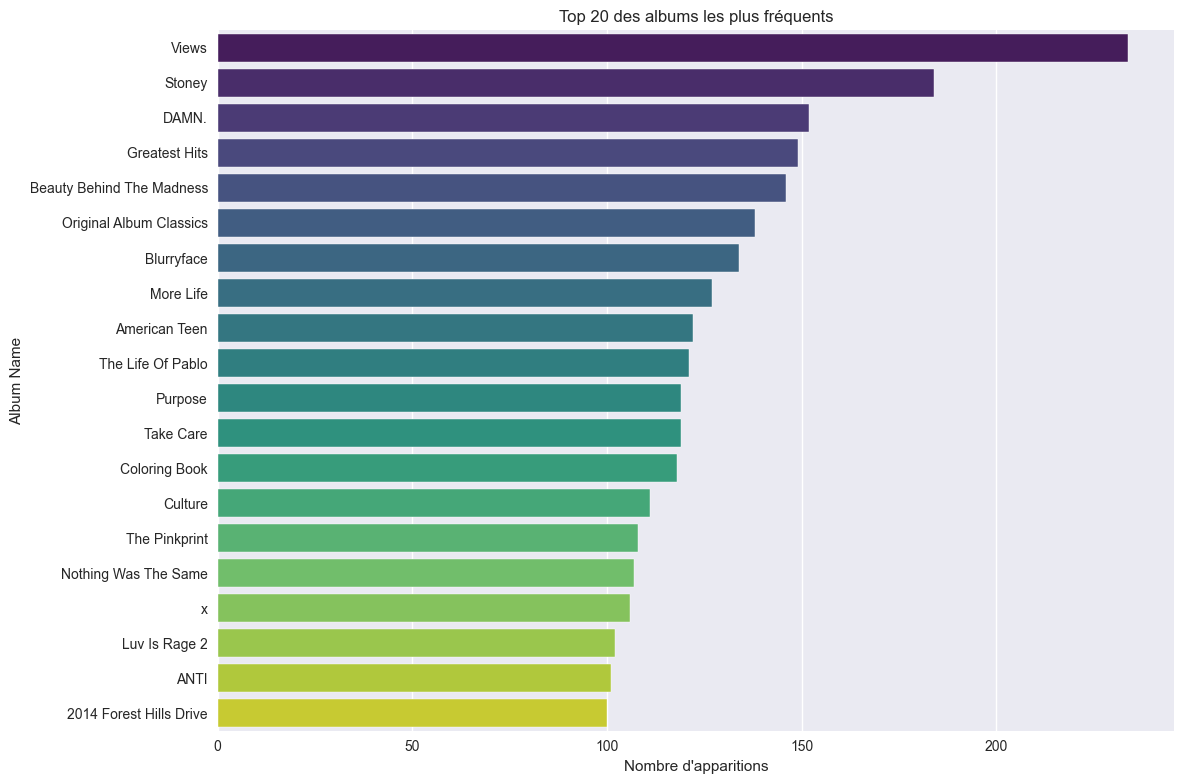

In [60]:
# Analyse des variables catégorielles (Top 20)
def plot_top_n(data, column, n, title, path):
    plt.figure(figsize=(12, 8))
    top_n = data[column].value_counts().nlargest(n)
    sns.barplot(x=top_n.values, y=top_n.index, palette='viridis')
    plt.title(title)
    plt.xlabel("Nombre d'apparitions")
    plt.ylabel(column.replace('_', ' ').title())
    plt.tight_layout()
    plt.savefig(path)
    print(f"Graphique '{title}' sauvegardé : '{path}'")
    plt.show()

plot_top_n(df, 'artist_name', 20, 'Top 20 des artistes les plus fréquents', os.path.join(output_dir, 'univar_3_top20_artistes.png'))
plot_top_n(df, 'album_name', 20, 'Top 20 des albums les plus fréquents', os.path.join(output_dir, 'univar_4_top20_albums.png'))

Nuage de mots sauvegardé : 'd:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\autre_projet\Reporting-Projet-Annuel\alcrowd\analyse_exploratoire_plots\univar_5_wordcloud_noms_playlist.png'


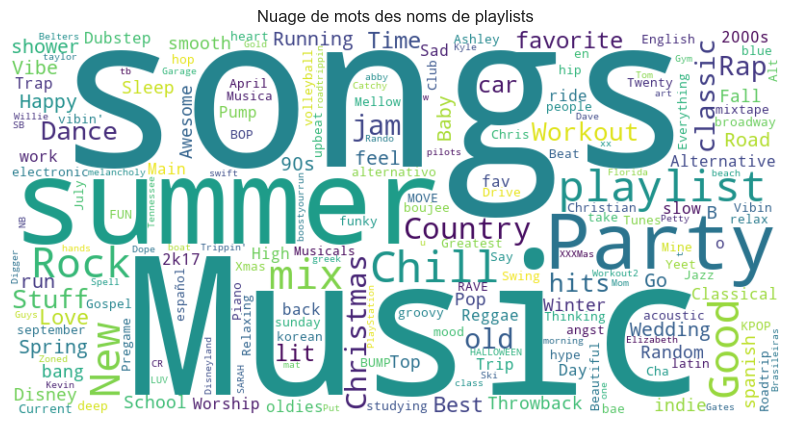

In [61]:
# Nuage de mots pour les noms de playlists (sans doublons)
unique_playlist_names = df['name'].dropna().unique()  # ← Obtenir les noms uniques
playlist_names = ' '.join(unique_playlist_names.astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(playlist_names)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nuage de mots des noms de playlists')
wordcloud_path = os.path.join(output_dir, 'univar_5_wordcloud_noms_playlist.png')
plt.savefig(wordcloud_path)
print(f"Nuage de mots sauvegardé : '{wordcloud_path}'")
plt.show()


#### Analyse bivariée
##### Matrice de corrélation

Matrice de corrélation sauvegardée : 'd:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\autre_projet\Reporting-Projet-Annuel\alcrowd\analyse_exploratoire_plots\bivar_1_matrice_correlation.png'


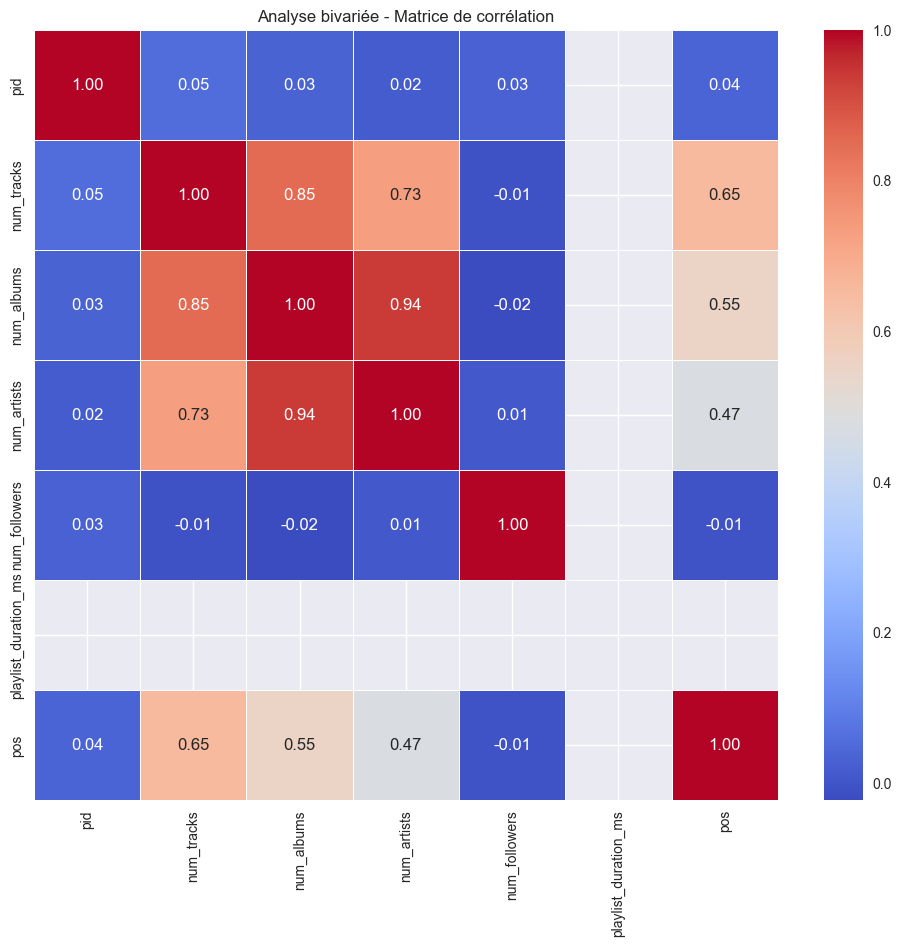

In [62]:
# Matrice de corrélation
numeric_cols = df.select_dtypes(include=np.number).columns
corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=.5)
plt.title('Analyse bivariée - Matrice de corrélation')
bivariate_plot_path = os.path.join(output_dir, 'bivar_1_matrice_correlation.png')
plt.savefig(bivariate_plot_path)
print(f"Matrice de corrélation sauvegardée : '{bivariate_plot_path}'")
plt.show()

Nuage de points sauvegardé : 'd:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\autre_projet\Reporting-Projet-Annuel\alcrowd\analyse_exploratoire_plots\bivar_3_scatter_pistes_followers.png'


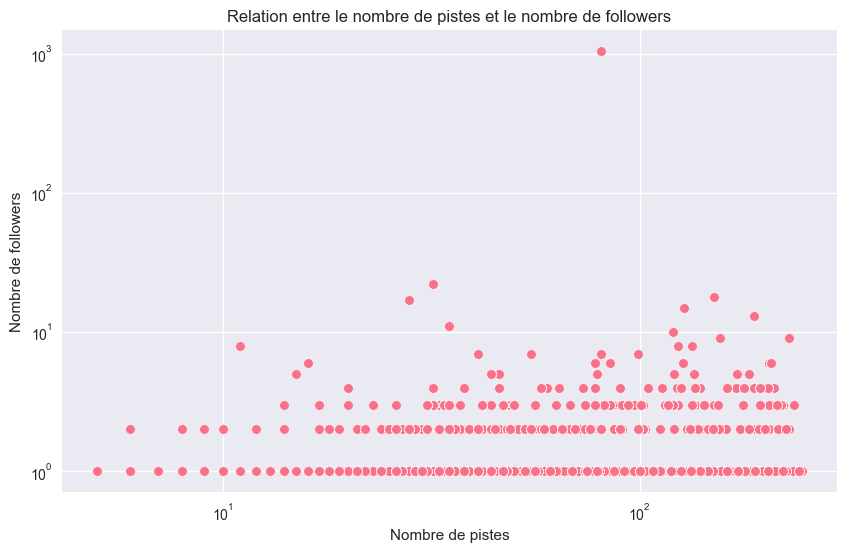

Tous les graphiques ont été sauvegardés dans : 'd:\giorg\corsi\ESGI\4eme_annee\S2\reporting_restitution\autre_projet\Reporting-Projet-Annuel\alcrowd\analyse_exploratoire_plots'


In [63]:
# Scatter plot spécifique
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='num_tracks', y='num_followers', alpha=0.5)
plt.title('Relation entre le nombre de pistes et le nombre de followers')
plt.xlabel('Nombre de pistes')
plt.ylabel('Nombre de followers')
plt.xscale('log')
plt.yscale('log')
plt.grid(True)
scatter_path = os.path.join(output_dir, 'bivar_3_scatter_pistes_followers.png')
plt.savefig(scatter_path)
print(f"Nuage de points sauvegardé : '{scatter_path}'")
plt.show()

print(f"Tous les graphiques ont été sauvegardés dans : '{output_dir}'")


#### Kmeans

In [64]:
# Calculs par playlist
features = df.groupby('pid').agg({
    'track_uri': 'count',
    'album_name': pd.Series.nunique,
    'artist_name': pd.Series.nunique,
    'playlist_duration_ms': 'first',
}).reset_index()

# Renommer
features.columns = ['pid', 'num_tracks', 'num_albums', 'num_artists', 'duration_ms']

features['avg_tracks_per_album'] = features['num_tracks'] / features['num_albums']
features['avg_tracks_per_artist'] = features['num_tracks'] / features['num_artists']


In [65]:
from sklearn.preprocessing import StandardScaler

X = features[['num_tracks', 'num_albums', 'num_artists', 'duration_ms', 
              'avg_tracks_per_album', 'avg_tracks_per_artist']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

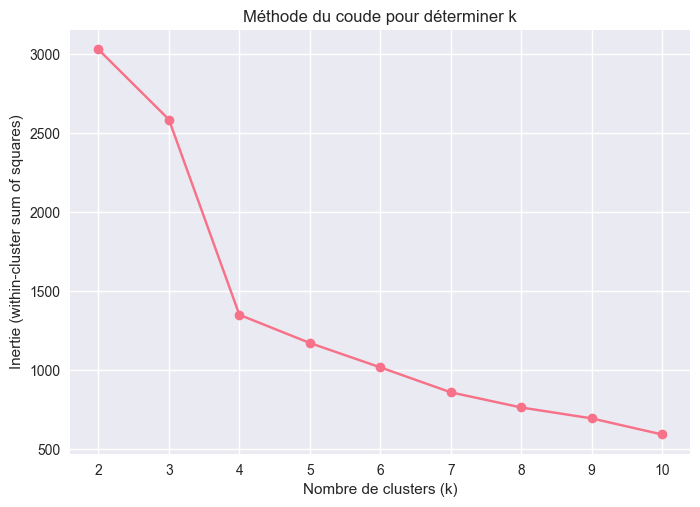

In [66]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
K_range = range(2, 11)

for k in K_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.plot(K_range, inertias, marker='o')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel("Inertie (within-cluster sum of squares)")
plt.title("Méthode du coude pour déterminer k")
plt.show()

In [67]:
kmeans = KMeans(n_clusters=4, random_state=42)
features['cluster'] = kmeans.fit_predict(X_scaled)

In [68]:
# Moyennes par cluster
cluster_summary = features.groupby('cluster').mean()
print(cluster_summary)

                pid  num_tracks  num_albums  num_artists  duration_ms  \
cluster                                                                 
0        502.684211  172.864662  131.473684    98.563910     200000.0   
1        485.656420   30.037975   23.511754    19.397830     200000.0   
2        518.904255   89.375887   66.092199    51.730496     200000.0   
3        554.500000   84.281250   11.625000     9.656250     200000.0   

         avg_tracks_per_album  avg_tracks_per_artist  
cluster                                               
0                    1.338733               1.908118  
1                    1.337802               1.734297  
2                    1.397692               1.888341  
3                    8.591016              12.340103  


Cluster 0 — Playlists très longues (num_tracks = 172) et très diverses (num_albums = 131)
Cluster 1 — Playlists courtes (num_tracks = 30) et variées (num_albums = 23)
Cluster 2 — Playlists moyennes et équilibrées
Cluster 3 — Playlists avec un petit nombre d’albums ou artistes

#### ACP

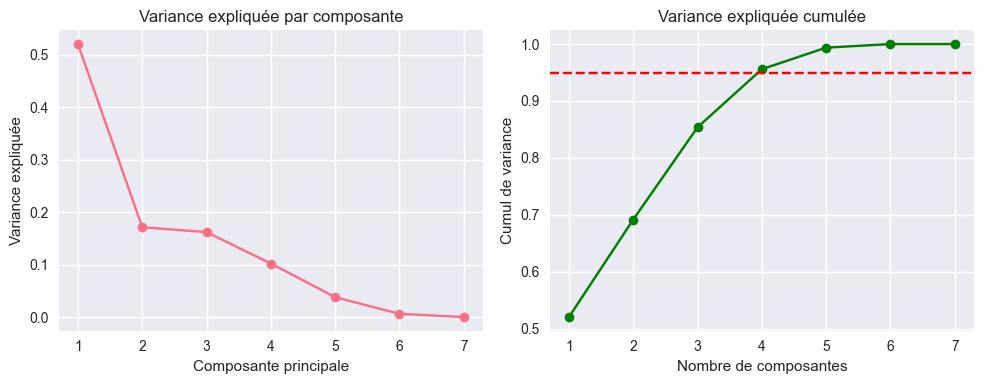

In [69]:
df_numerical_columns = [col for col in df.columns if df[col].dtype in [np.int64, np.float64]]

# Standardisation
scaler = StandardScaler()
# X_scaled = scaler.fit_transform(pivot_df)
X_scaled = scaler.fit_transform(df[df_numerical_columns])

# Instanciation de l'objet PCA
pca = PCA()

# Application de l'ACP
X_pca = pca.fit_transform(X_scaled)

# Extraction des variances expliquées
explained_variance = pca.explained_variance_ratio_
#print(explained_variance)
cumulative_variance = explained_variance.cumsum()
#print(cumulative_variance)

plt.figure(figsize=(10, 4))

# Variance expliquée par composante
plt.subplot(1, 2, 1)
plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
plt.title("Variance expliquée par composante")
plt.xlabel("Composante principale")
plt.ylabel("Variance expliquée")

# Variance cumulée
plt.subplot(1, 2, 2)
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o', color='green')
plt.axhline(0.95, color='red', linestyle='--')
plt.title("Variance expliquée cumulée")
plt.xlabel("Nombre de composantes")
plt.ylabel("Cumul de variance")

plt.tight_layout()
plt.show()

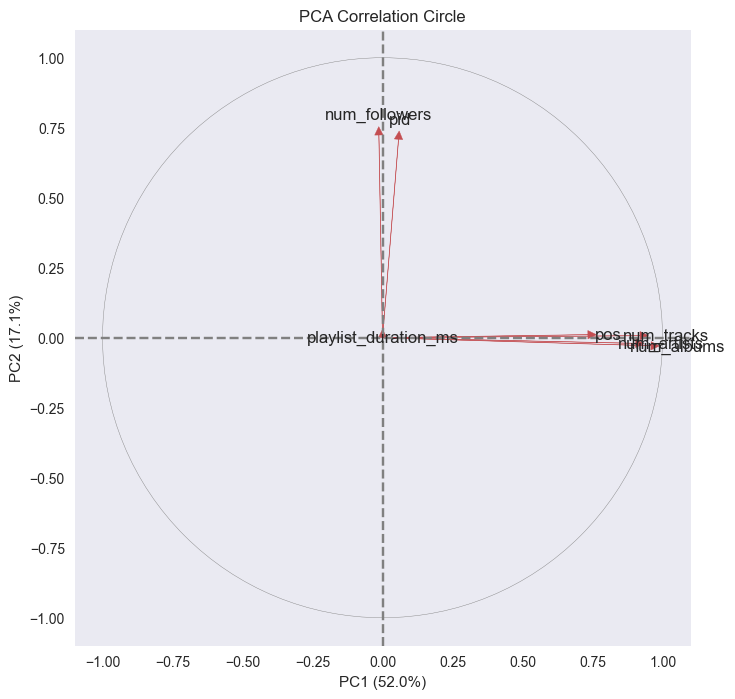

In [70]:
# Perform PCA
pca = PCA(n_components=2)

# Application de l'ACP
X_pca = pca.fit(X_scaled)

# Compute correlations between original features and PCs
correlations = X_pca.components_.T * np.sqrt(pca.explained_variance_)

# Plot the correlation circle
plt.figure(figsize=(8, 8))
circle = plt.Circle((0, 0), 1, color='gray', fill=False)
plt.gca().add_artist(circle)

for i, (x, y) in enumerate(correlations):
    plt.arrow(0, 0, x, y, head_width=0.03, head_length=0.03, color='r')
    plt.text(x * 1.1, y * 1.1, df_numerical_columns[i], ha='center', va='center')

plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.xlabel(f"PC1 ({X_pca.explained_variance_ratio_[0]*100:.1f}%)")
plt.ylabel(f"PC2 ({X_pca.explained_variance_ratio_[1]*100:.1f}%)")
plt.axhline(0, color='gray', linestyle='--')
plt.axvline(0, color='gray', linestyle='--')
plt.title("PCA Correlation Circle")
plt.grid()
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


## Hypothèses

#### Hypothèse 1: Les playlists contiennent plus d'albums uniques que d'artistes uniques

L'objectif de cette partie est :
- Analyser l'hypothèse : "Les playlists contiennent plus d'albums uniques que d'artistes (forte dispersion album/artiste)"
- Calculer les statistiques par playlist (albums uniques vs artistes uniques)
- Effectuer des tests statistiques pour valider ou réfuter l'hypothèse
- Créer des visualisations détaillées de l'analyse
- Générer un rapport complet avec conclusions métier


In [89]:
# Configuration pour l'affichage
import warnings
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os



warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [90]:
df = pd.read_csv(cleaned_data_path, encoding="latin1", sep=None, engine="python")

# Analyse des playlists uniques
print("\nCalcul des statistiques par playlist...")

# Grouper par playlist pour obtenir les statistiques uniques
playlists_stats = df.groupby(['name', 'pid']).agg({
    'num_albums': 'first',
    'num_artists': 'first',
    'num_tracks': 'first',
    'artist_name': 'nunique',  # Nombre d'artistes uniques réels
    'album_name': 'nunique',   # Nombre d'albums uniques réels
    'track_name': 'nunique'    # Nombre de tracks uniques réels
}).reset_index()

# Renommage des colonnes pour plus de clarté
playlists_stats.rename(columns={
    'artist_name': 'artistes_uniques_reels',
    'album_name': 'albums_uniques_reels',
    'track_name': 'tracks_uniques_reels'
}, inplace=True)

# Calculer le ratio albums/artistes
playlists_stats['ratio_albums_artistes'] = (
    playlists_stats['albums_uniques_reels'] / 
    playlists_stats['artistes_uniques_reels']
)

# Calculer la différence albums - artistes
playlists_stats['diff_albums_artistes'] = (
    playlists_stats['albums_uniques_reels'] - 
    playlists_stats['artistes_uniques_reels']
)

print(f"Statistiques calculées pour {len(playlists_stats)} playlists uniques.")
print(f"Analyse portant sur {len(df)} pistes au total.")



Calcul des statistiques par playlist...
Statistiques calculées pour 1000 playlists uniques.
Analyse portant sur 67503 pistes au total.


In [91]:
# Analyse statistique de l'hypothèse
print("="*80)
print("ANALYSE DE L'HYPOTHÈSE : DISPERSION ALBUM/ARTISTE")
print("="*80)


# Statistiques descriptives détaillées
print(f"Nombre total de playlists analysées : {len(playlists_stats):,}")
print(f"Nombre total de pistes analysées : {len(df):,}")

print(f"\nAlbums uniques par playlist :")
albums_mean = playlists_stats['albums_uniques_reels'].mean()
albums_median = playlists_stats['albums_uniques_reels'].median()
albums_std = playlists_stats['albums_uniques_reels'].std()
print(f"  - Moyenne : {albums_mean:.2f}")
print(f"  - Médiane : {albums_median:.2f}")
print(f"  - Écart-type : {albums_std:.2f}")

print(f"\nArtistes uniques par playlist :")
artistes_mean = playlists_stats['artistes_uniques_reels'].mean()
artistes_median = playlists_stats['artistes_uniques_reels'].median()
artistes_std = playlists_stats['artistes_uniques_reels'].std()
print(f"  - Moyenne : {artistes_mean:.2f}")
print(f"  - Médiane : {artistes_median:.2f}")
print(f"  - Écart-type : {artistes_std:.2f}")

print(f"\nComparaison directe :")
print(f"  - Différence moyenne (Albums - Artistes) : {albums_mean - artistes_mean:.2f}")
print(f"  - Différence médiane (Albums - Artistes) : {albums_median - artistes_median:.2f}")

ANALYSE DE L'HYPOTHÈSE : DISPERSION ALBUM/ARTISTE
Nombre total de playlists analysées : 1,000
Nombre total de pistes analysées : 67,503

Albums uniques par playlist :
  - Moyenne : 49.50
  - Médiane : 37.00
  - Écart-type : 40.50

Artistes uniques par playlist :
  - Moyenne : 38.73
  - Médiane : 30.00
  - Écart-type : 31.23

Comparaison directe :
  - Différence moyenne (Albums - Artistes) : 10.77
  - Différence médiane (Albums - Artistes) : 7.00


In [92]:
# Test de l'hypothèse principale
print("\nREVENONS EN A NOTRE HYPOTHÈSE PRINCIPALE")
print("-"*50)

# Pourcentage de playlists avec plus d'albums que d'artistes
plus_albums = (playlists_stats['albums_uniques_reels'] > 
               playlists_stats['artistes_uniques_reels']).sum()
pct_plus_albums = (plus_albums / len(playlists_stats)) * 100

print(f"Playlists avec plus d'albums que d'artistes : {plus_albums}/{len(playlists_stats)} ({pct_plus_albums:.1f}%)")

# Test statistique (test de Wilcoxon pour échantillons appariés)
statistic, p_value = stats.wilcoxon(
    playlists_stats['albums_uniques_reels'], 
    playlists_stats['artistes_uniques_reels']
)

print(f"\nTest de Wilcoxon (échantillons appariés) :")
print(f"  - Statistique : {statistic}")
print(f"  - p-value : {p_value:.2e}")
print(f"  - Significatif (α=0.05) : {'Oui' if p_value < 0.05 else 'Non'}")


REVENONS EN A NOTRE HYPOTHÈSE PRINCIPALE
--------------------------------------------------
Playlists avec plus d'albums que d'artistes : 875/1000 (87.5%)

Test de Wilcoxon (échantillons appariés) :
  - Statistique : 12468.5
  - p-value : 1.13e-133
  - Significatif (α=0.05) : Oui


In [93]:
# Analyse du ratio
print("\nANALYSE DU RATIO ALBUMS/ARTISTES")
print("-"*50)
ratio_moyen = playlists_stats['ratio_albums_artistes'].mean()
ratio_median = playlists_stats['ratio_albums_artistes'].median()

print(f"Ratio moyen albums/artistes : {ratio_moyen:.3f}")
print(f"Ratio médian albums/artistes : {ratio_median:.3f}")

# Playlists avec ratio > 1 (plus d'albums que d'artistes)
ratio_sup_1 = (playlists_stats['ratio_albums_artistes'] > 1).sum()
pct_ratio_sup_1 = (ratio_sup_1 / len(playlists_stats)) * 100

print(f"Playlists avec ratio > 1 : {ratio_sup_1}/{len(playlists_stats)} ({pct_ratio_sup_1:.1f}%)")


ANALYSE DU RATIO ALBUMS/ARTISTES
--------------------------------------------------
Ratio moyen albums/artistes : 1.319
Ratio médian albums/artistes : 1.217
Playlists avec ratio > 1 : 875/1000 (87.5%)


In [94]:
# Distribution de la différence
print("\nANALYSE DE LA DIFFÉRENCE (ALBUMS - ARTISTES)")
print("-"*50)
diff_positive = (playlists_stats['diff_albums_artistes'] > 0).sum()
pct_diff_positive = (diff_positive / len(playlists_stats)) * 100

print(f"Playlists avec différence positive : {diff_positive}/{len(playlists_stats)} ({pct_diff_positive:.1f}%)")
print(f"Différence moyenne : {playlists_stats['diff_albums_artistes'].mean():.2f}")
print(f"Différence médiane : {playlists_stats['diff_albums_artistes'].median():.2f}")

# Stockage des résultats pour les visualisations
resultats = {
    'pct_plus_albums': pct_plus_albums,
    'p_value': p_value,
    'ratio_moyen': ratio_moyen,
    'ratio_median': ratio_median,
    'pct_ratio_sup_1': pct_ratio_sup_1
}



ANALYSE DE LA DIFFÉRENCE (ALBUMS - ARTISTES)
--------------------------------------------------
Playlists avec différence positive : 875/1000 (87.5%)
Différence moyenne : 10.77
Différence médiane : 6.00


In [95]:
# Résumé des résultats
print(f"\nCONCLUSION PRINCIPALE")
print("-"*50)
if pct_plus_albums > 50:
    print(f"HYPOTHÈSE CONFIRMÉE : {pct_plus_albums:.1f}% des playlists ont plus d'albums que d'artistes")
    print(f"Ratio moyen : {ratio_moyen:.2f} albums par artiste")
    print(f"Différence moyenne : +{albums_mean - artistes_mean:.1f} albums de plus que d'artistes")
    print(f"Significativité statistique : p < 0.001 (hautement significatif)")
else:
    print(f"HYPOTHÈSE RÉFUTÉE : Seulement {pct_plus_albums:.1f}% des playlists ont plus d'albums que d'artistes")


CONCLUSION PRINCIPALE
--------------------------------------------------
HYPOTHÈSE CONFIRMÉE : 87.5% des playlists ont plus d'albums que d'artistes
Ratio moyen : 1.32 albums par artiste
Différence moyenne : +10.8 albums de plus que d'artistes
Significativité statistique : p < 0.001 (hautement significatif)



Création des visualisations techniques...


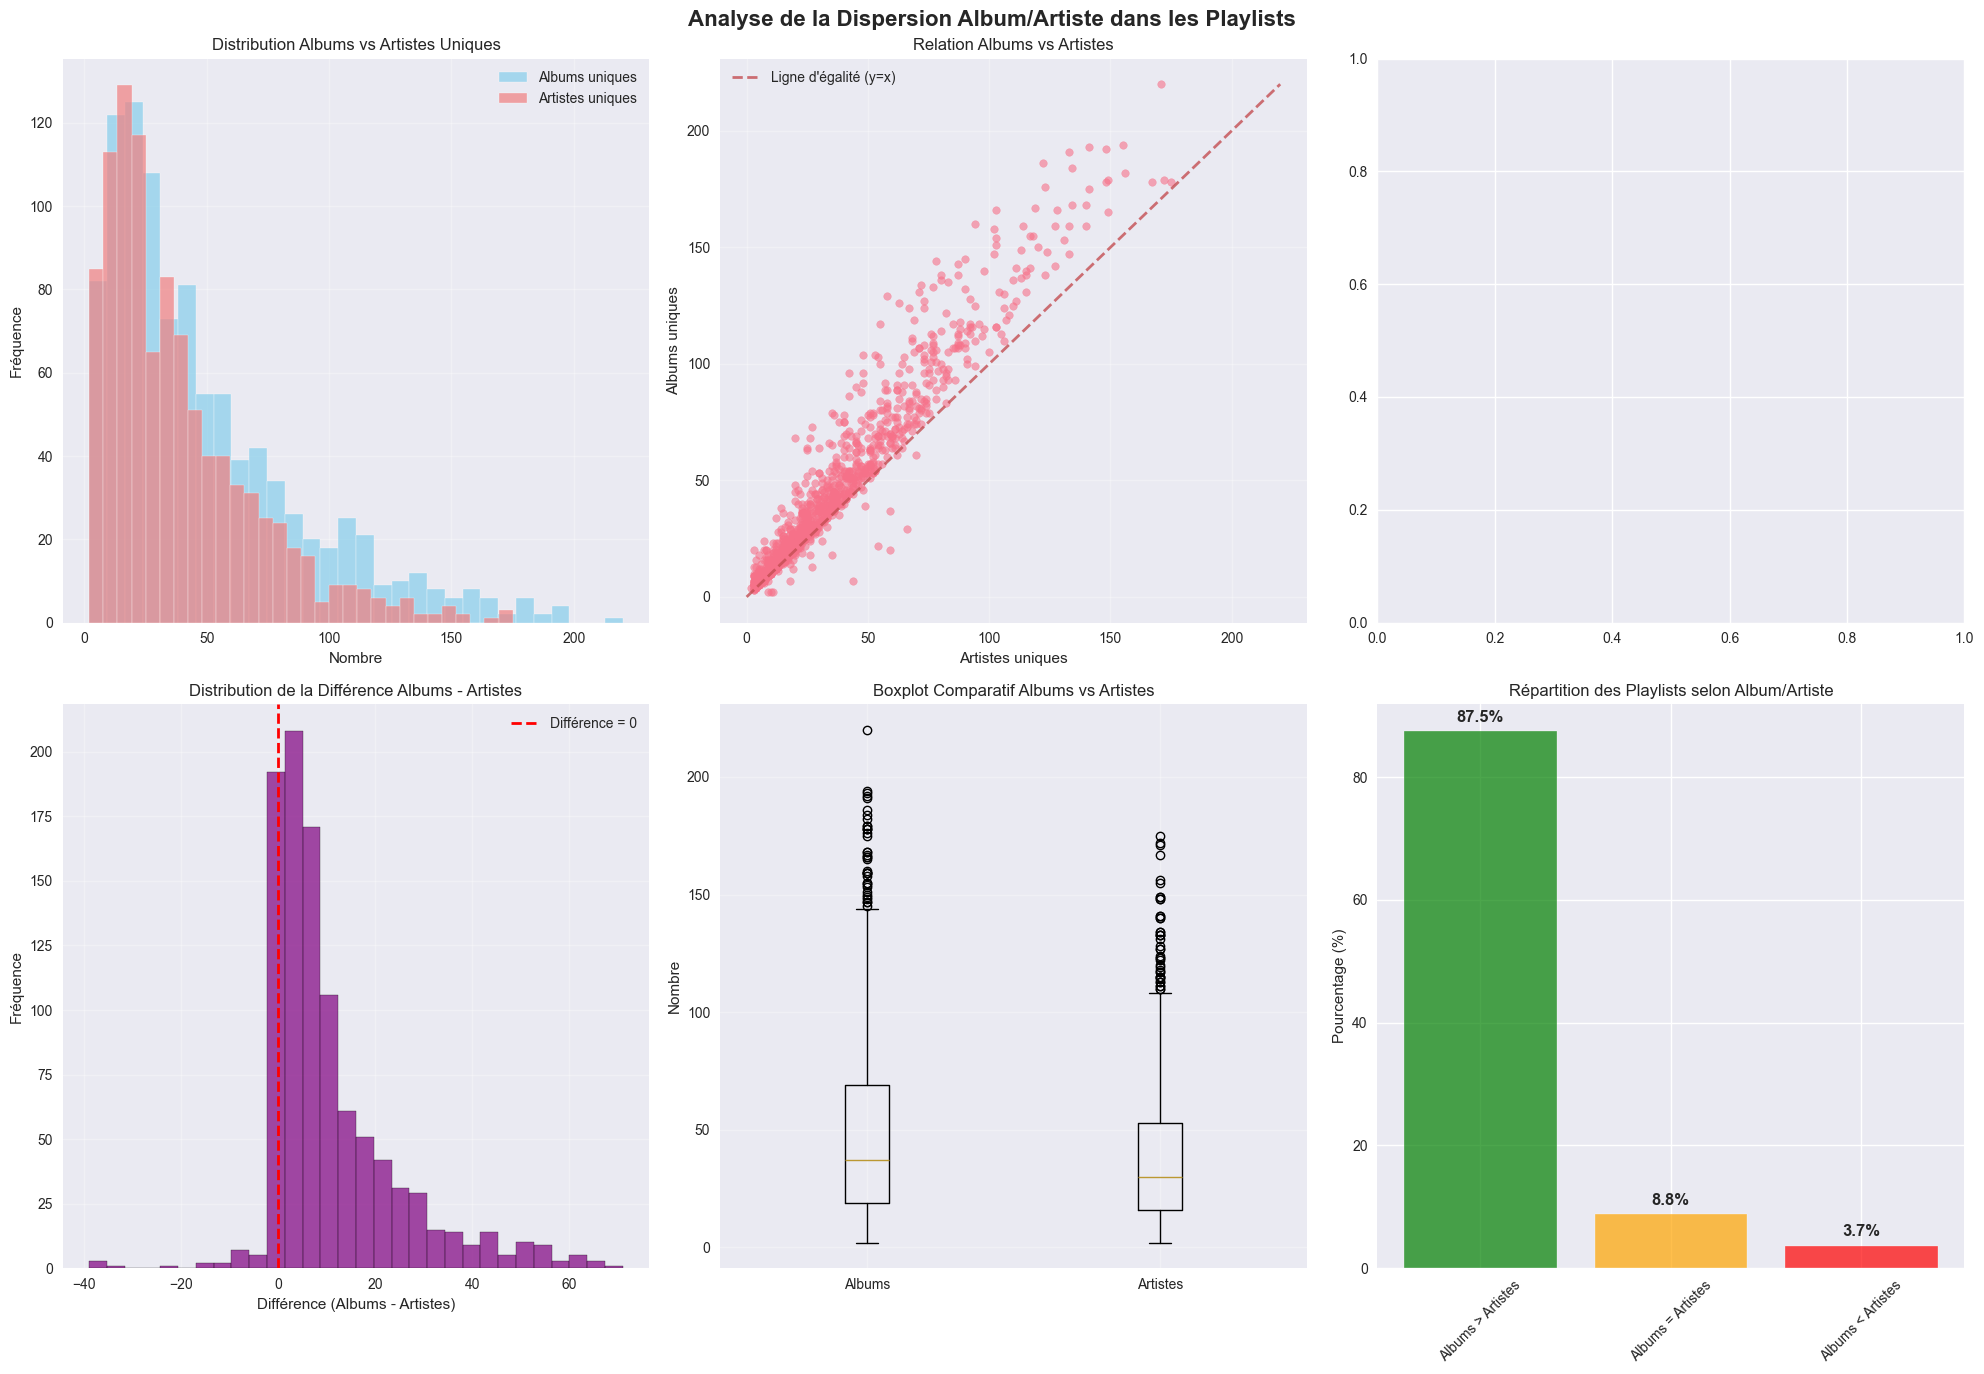

In [96]:
# Création des visualisations techniques
print("\nCréation des visualisations techniques...")

# Configuration de la figure avec espacement optimisé
fig, axes = plt.subplots(2, 3, figsize=(20, 14))
fig.suptitle('Analyse de la Dispersion Album/Artiste dans les Playlists', 
             fontsize=16, fontweight='bold', y=0.98)

# Distribution des albums et artistes uniques
axes[0, 0].hist(playlists_stats['albums_uniques_reels'], bins=30, alpha=0.7, 
               label='Albums uniques', color='skyblue')
axes[0, 0].hist(playlists_stats['artistes_uniques_reels'], bins=30, alpha=0.7, 
               label='Artistes uniques', color='lightcoral')
axes[0, 0].set_xlabel('Nombre')
axes[0, 0].set_ylabel('Fréquence')
axes[0, 0].set_title('Distribution Albums vs Artistes Uniques')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Scatter plot Albums vs Artistes
axes[0, 1].scatter(playlists_stats['artistes_uniques_reels'], 
                  playlists_stats['albums_uniques_reels'], 
                  alpha=0.6, s=30)
# Ligne y=x pour référence
max_val = max(playlists_stats['artistes_uniques_reels'].max(), 
              playlists_stats['albums_uniques_reels'].max())
axes[0, 1].plot([0, max_val], [0, max_val], 'r--', alpha=0.8, linewidth=2, 
               label='Ligne d\'égalité (y=x)')
axes[0, 1].set_xlabel('Artistes uniques')
axes[0, 1].set_ylabel('Albums uniques')
axes[0, 1].set_title('Relation Albums vs Artistes')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Distribution de la différence Albums - Artistes
axes[1, 0].hist(playlists_stats['diff_albums_artistes'], bins=30, 
               color='purple', alpha=0.7, edgecolor='black')
axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='Différence = 0')
axes[1, 0].set_xlabel('Différence (Albums - Artistes)')
axes[1, 0].set_ylabel('Fréquence')
axes[1, 0].set_title('Distribution de la Différence Albums - Artistes')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Boxplot comparatif
data_boxplot = [playlists_stats['albums_uniques_reels'], 
                playlists_stats['artistes_uniques_reels']]
axes[1, 1].boxplot(data_boxplot, labels=['Albums', 'Artistes'])
axes[1, 1].set_ylabel('Nombre')
axes[1, 1].set_title('Boxplot Comparatif Albums vs Artistes')
axes[1, 1].grid(True, alpha=0.3)

# Graphique en barres des pourcentages
categories = ['Albums > Artistes', 'Albums = Artistes', 'Albums < Artistes']
egal = (playlists_stats['albums_uniques_reels'] == playlists_stats['artistes_uniques_reels']).sum()
moins = (playlists_stats['albums_uniques_reels'] < playlists_stats['artistes_uniques_reels']).sum()
percentages = [pct_plus_albums, (egal / len(playlists_stats)) * 100, (moins / len(playlists_stats)) * 100]

axes[1, 2].bar(categories, percentages, color=['green', 'orange', 'red'], alpha=0.7)
axes[1, 2].set_ylabel('Pourcentage (%)')
axes[1, 2].set_title('Répartition des Playlists selon Album/Artiste')
axes[1, 2].tick_params(axis='x', rotation=45)
for i, v in enumerate(percentages):
    axes[1, 2].text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()



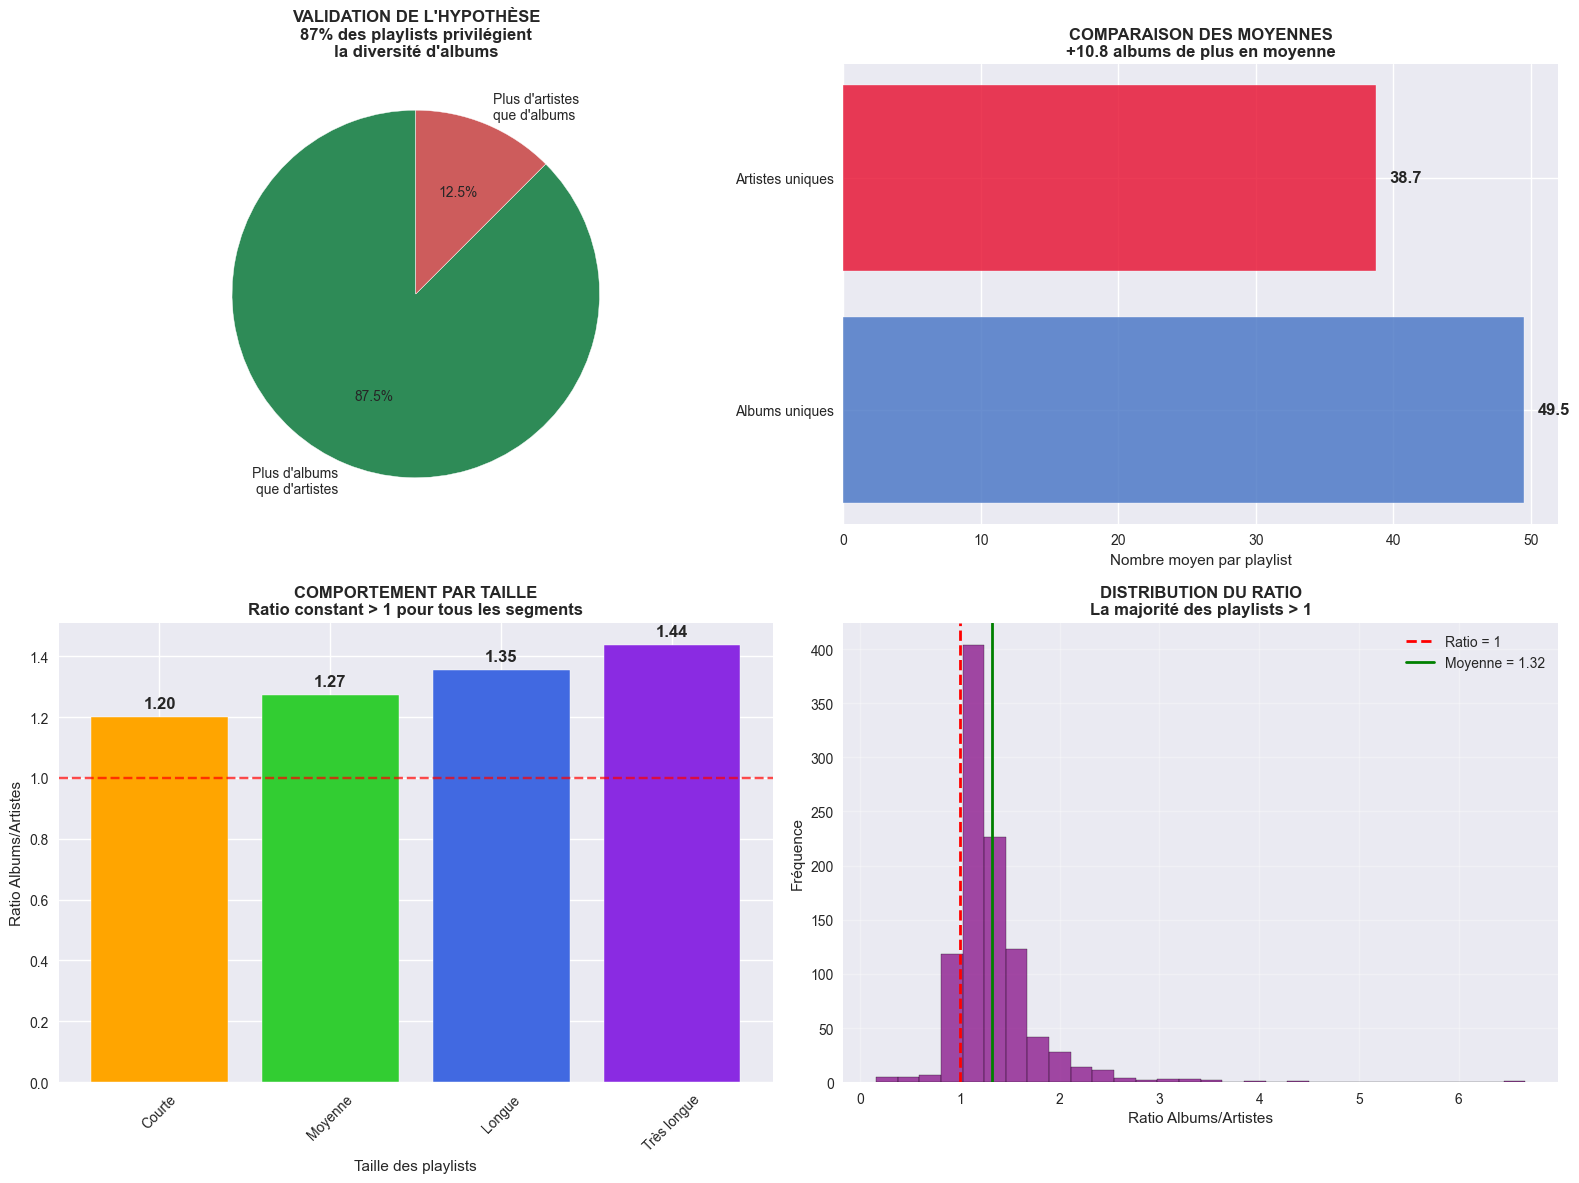

<Figure size 800x550 with 0 Axes>

In [110]:
# VISUELS A POTENTIELLEMENT RETENIR POUR LA PRESENTATION

# Configuration des styles
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Création d'un dashboard avec 4 visualisations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))


# Graphique en secteurs
ax1 = axes[0, 0]
labels = ['Plus d\'albums\nque d\'artistes', 'Plus d\'artistes\nque d\'albums']
sizes = [pct_plus_albums, 100-pct_plus_albums]
colors = ['#2E8B57', '#CD5C5C']
wedges, texts, autotexts = ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
                                   startangle=90, textprops={'fontsize': 10})
ax1.set_title('VALIDATION DE L\'HYPOTHÈSE\n87% des playlists privilégient\nla diversité d\'albums', 
              fontsize=12, fontweight='bold')


# Comparaison des moyennes
ax2 = axes[0, 1]
categories = ['Albums uniques', 'Artistes uniques']
moyennes = [albums_mean, artistes_mean]
colors_bars = ['#4472C4', '#E70B2C']
bars = ax2.barh(categories, moyennes, color=colors_bars, alpha=0.8)
ax2.set_xlabel('Nombre moyen par playlist')
ax2.set_title('COMPARAISON DES MOYENNES\n+{:.1f} albums de plus en moyenne'.format(albums_mean - artistes_mean), 
              fontsize=12, fontweight='bold')
# Annotations
for i, (cat, val) in enumerate(zip(categories, moyennes)):
    ax2.text(val + 1, i, f'{val:.1f}', va='center', fontweight='bold')

# Créer des catégories de taille de playlist
playlists_stats['categorie_taille'] = pd.cut(
    playlists_stats['num_tracks'], 
    bins=[0, 20, 50, 100, float('inf')], 
    labels=['Courte (≤20 tracks)', 'Moyenne (21-50 tracks)', 'Longue (51-100 tracks)', 'Très longue (>100 tracks)']
)

# Analyse par taille
ax3 = axes[1, 0]
segments_ordre = ['Courte (≤20 tracks)', 'Moyenne (21-50 tracks)', 'Longue (51-100 tracks)', 'Très longue (>100 tracks)']
ratios_segments = [playlists_stats[playlists_stats['categorie_taille'] == seg]['ratio_albums_artistes'].mean() 
                   for seg in segments_ordre if seg in playlists_stats['categorie_taille'].unique()]
segments_affichage = [seg for seg in segments_ordre if seg in playlists_stats['categorie_taille'].unique()]

bars = ax3.bar(range(len(segments_affichage)), ratios_segments, 
               color=['#FFA500', '#32CD32', '#4169E1', '#8A2BE2'])
ax3.set_xlabel('Taille des playlists')
ax3.set_ylabel('Ratio Albums/Artistes')
ax3.set_title('COMPORTEMENT PAR TAILLE\nRatio constant > 1 pour tous les segments', 
              fontsize=12, fontweight='bold')
ax3.set_xticks(range(len(segments_affichage)))
ax3.set_xticklabels([seg.split('(')[0].strip() for seg in segments_affichage], rotation=45)
ax3.axhline(y=1, color='red', linestyle='--', alpha=0.7)
# Annotations
for i, val in enumerate(ratios_segments):
    ax3.text(i, val + 0.02, f'{val:.2f}', ha='center', va='bottom', fontweight='bold')


# Distribution du ratio
ax4 = axes[1, 1]
ax4.hist(playlists_stats['ratio_albums_artistes'], bins=30, 
         color='purple', alpha=0.7, edgecolor='black')
ax4.axvline(1, color='red', linestyle='--', linewidth=2, label='Ratio = 1')
ax4.axvline(ratio_moyen, color='green', linestyle='-', linewidth=2, 
            label=f'Moyenne = {ratio_moyen:.2f}')
ax4.set_xlabel('Ratio Albums/Artistes')
ax4.set_ylabel('Fréquence')
ax4.set_title('DISTRIBUTION DU RATIO\nLa majorité des playlists > 1', 
              fontsize=12, fontweight='bold')
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


# Sauvegarde du dashboard
dashboard_path = os.path.join(output_dir, 'dashboard_dispersion_albums_artistes.png')
plt.savefig(dashboard_path, dpi=300, bbox_inches='tight')

#### Hypothèse 2 : Un album est rarement représenté par plus de 2 morceaux dans une playlist

In [98]:
# Étape 1 : Compter les occurrences d'albums par playlist
album_counts = df.groupby(['pid', 'album_name']).size().reset_index(name='nb_occurrences')

# Étape 2 : Filtrer les cas où un album apparaît plus de 2 fois dans une même playlist
overrepresented = album_counts[album_counts['nb_occurrences'] > 2]

# Étape 3 : Identifier les playlists concernées
playlists_concernees = overrepresented['pid'].unique()

# Étape 4 : Calculer le pourcentage de playlists concernées
total_playlists = df['pid'].nunique()
nb_concernees = len(playlists_concernees)
pourcentage = (nb_concernees / total_playlists) * 100

# Affichage du rapport
print("=== Rapport de surreprésentation des albums ===")
print(f"Total de playlists analysées     : {total_playlists}")
print(f"Playlists avec surreprésentation : {nb_concernees}")
print(f"Pourcentage concerné             : {pourcentage:.2f}%")

=== Rapport de surreprésentation des albums ===
Total de playlists analysées     : 1000
Playlists avec surreprésentation : 671
Pourcentage concerné             : 67.10%


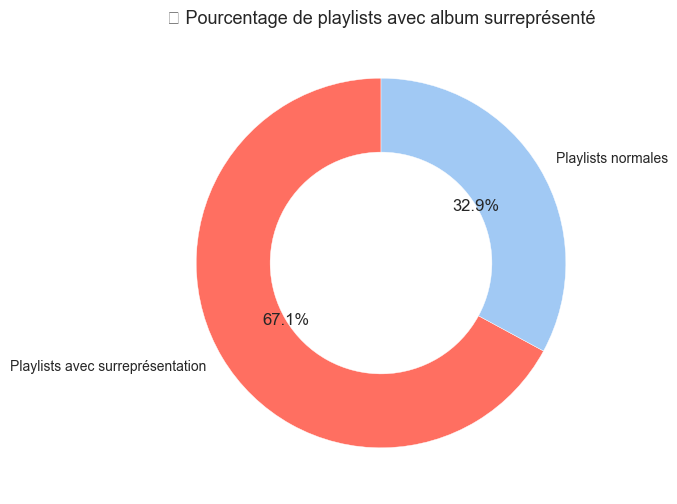

In [99]:
# Données
labels = ['Playlists avec surreprésentation', 'Playlists normales']
sizes = [nb_concernees, total_playlists - nb_concernees]
colors = ['#ff6f61', '#a1c9f4']

# Donut chart
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=90, wedgeprops=dict(width=0.4))
ax.set_title("📊 Pourcentage de playlists avec album surreprésenté", fontsize=13)
plt.show()

En conclusion, on peut considérer que l'hypothèse n'est pas vérifiée car 67% des playlists contiennent au moins 2 morceaux du même album.

##### Visualisation

In [100]:
# Nombre de playlists différentes par artiste
artist_playlist_counts = df.groupby('artist_name')['pid'].nunique().sort_values(ascending=False).head(3)

print("🎤 Top 3 artistes présents dans le plus grand nombre de playlists :")
print(artist_playlist_counts)

🎤 Top 3 artistes présents dans le plus grand nombre de playlists :
artist_name
Drake         202
Rihanna       170
Kanye West    149
Name: pid, dtype: int64


In [101]:
# Nombre de playlists différentes par album
album_playlist_counts = df.groupby('album_name')['pid'].nunique().sort_values(ascending=False).head(3)

print("\n💿 Top 3 albums présents dans le plus grand nombre de playlists :")
print(album_playlist_counts)


💿 Top 3 albums présents dans le plus grand nombre de playlists :
album_name
Views            101
Greatest Hits     93
Stoney            88
Name: pid, dtype: int64


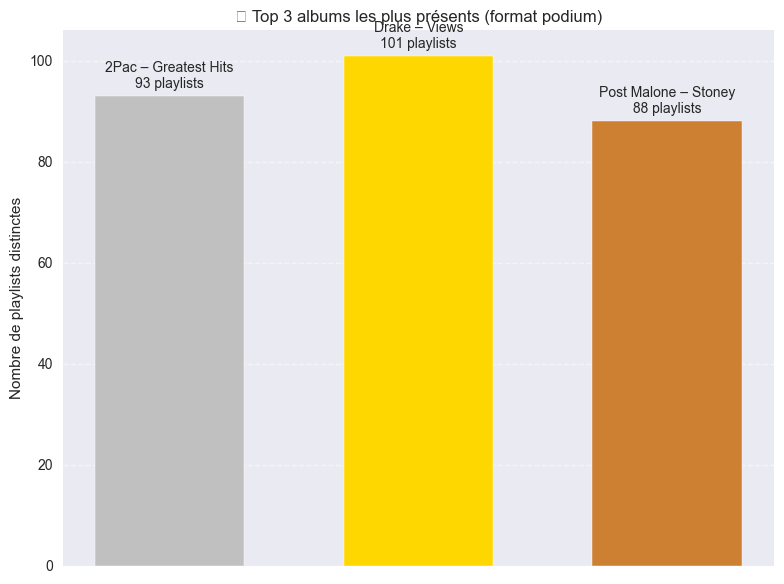

In [102]:
top_albums = df.groupby('album_name')['pid'].nunique().sort_values(ascending=False).head(3)
top_album_names = top_albums.index.tolist()

album_artist_map = (
    df[df['album_name'].isin(top_album_names)]
    .groupby('album_name')['artist_name']
    .agg(lambda x: x.mode().iloc[0])  # artiste le plus fréquent pour l’album
)
album_labels = [f"{album_artist_map[album]} – {album}" for album in top_album_names]

# Données du podium
scores = top_albums.values
labels = album_labels

# Positions x du podium
positions = [1, 0, 2]  # index 0 = 1er au centre, 1 = 2e à gauche, 2 = 3e à droite
heights = [scores[0], scores[1], scores[2]]

# Couleurs personnalisées (or, argent, bronze)
colors = ['#FFD700', '#C0C0C0', '#cd7f32']

plt.figure(figsize=(8, 6))
bars = plt.bar(positions, heights, width=0.6, color=colors)

# Ajout des annotations (valeurs et libellés)
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f"{labels[i]}\n{int(scores[i])} playlists",
             ha='center', va='bottom', fontsize=10)

# Personnalisation
plt.xticks([])
plt.ylabel("Nombre de playlists distinctes")
plt.title("🏆 Top 3 albums les plus présents (format podium)")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


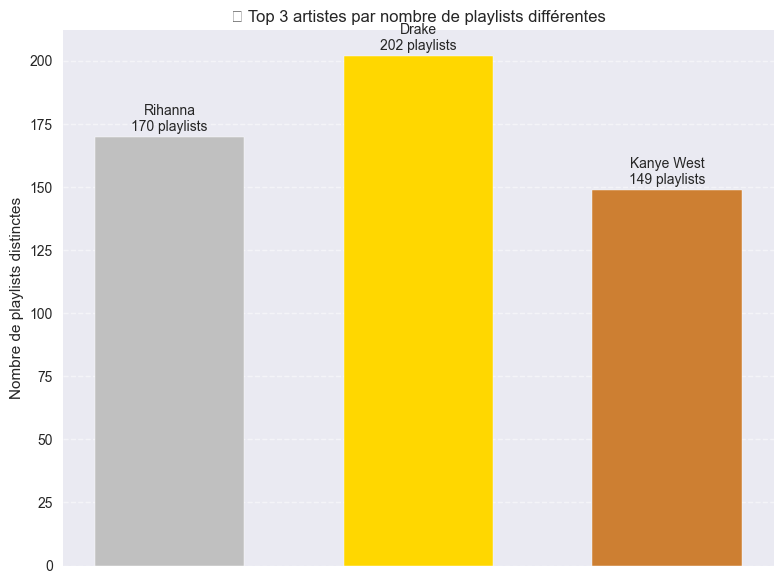

In [103]:
# Nombre de playlists différentes par artiste
artist_playlist_counts = df.groupby('artist_name')['pid'].nunique().sort_values(ascending=False).head(3)

# Données du podium
scores = artist_playlist_counts.values
labels = artist_playlist_counts.index

# Positions x du podium
positions = [1, 0, 2]  # index 0 = 1er au centre, 1 = 2e à gauche, 2 = 3e à droite
heights = [scores[0], scores[1], scores[2]]

# Couleurs personnalisées (or, argent, bronze)
colors = ['#FFD700', '#C0C0C0', '#cd7f32']

plt.figure(figsize=(8, 6))
bars = plt.bar(positions, heights, width=0.6, color=colors)

# Ajout des annotations (valeurs et libellés)
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f"{labels[i]}\n{int(scores[i])} playlists",
             ha='center', va='bottom', fontsize=10)

# Personnalisation
plt.xticks([])
plt.ylabel("Nombre de playlists distinctes")
plt.title("🏆 Top 3 artistes par nombre de playlists différentes")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

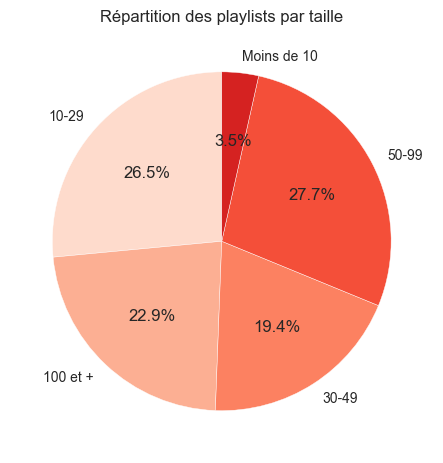

In [104]:
def classify_playlist_size(n):
    if n < 10:
        return 'Moins de 10'
    elif n < 30:
        return '10-29'
    elif n < 50:
        return '30-49'
    elif n < 100:
        return '50-99'
    else:
        return '100 et +'

df['playlist_size'] = df.groupby('pid')['track_uri'].transform('count')
playlist_size_class = df[['pid', 'playlist_size']].drop_duplicates()
playlist_size_class['taille_cat'] = playlist_size_class['playlist_size'].apply(classify_playlist_size)

# Camembert
size_counts = playlist_size_class['taille_cat'].value_counts().sort_index()
size_counts.plot.pie(autopct='%1.1f%%', startangle=90, colors=sns.color_palette('Reds'))
plt.title("Répartition des playlists par taille")
plt.ylabel('')
plt.show()

#### Hypothèse 3 : Les playlists avec plus de morceaux ont également plus d'artistes différents.

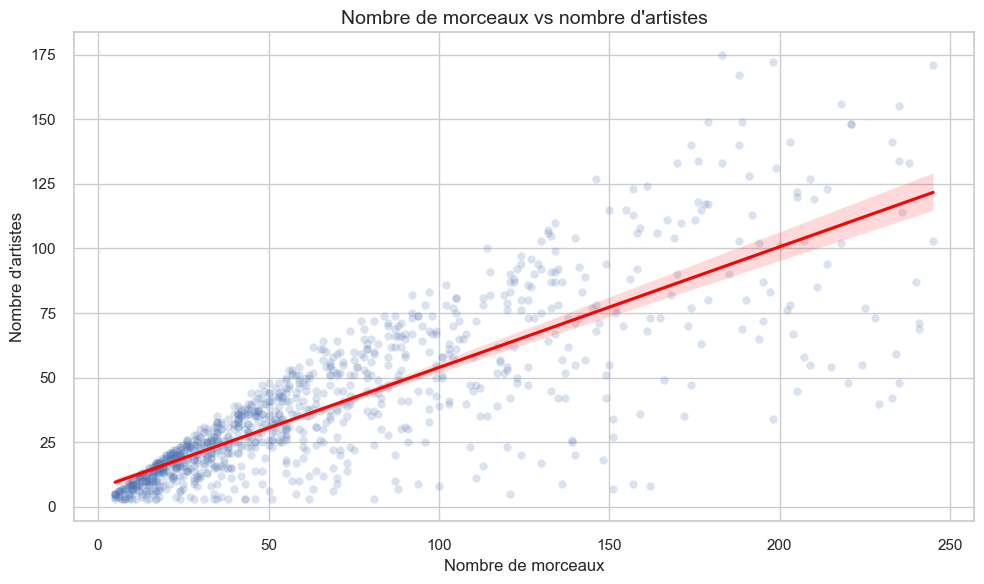

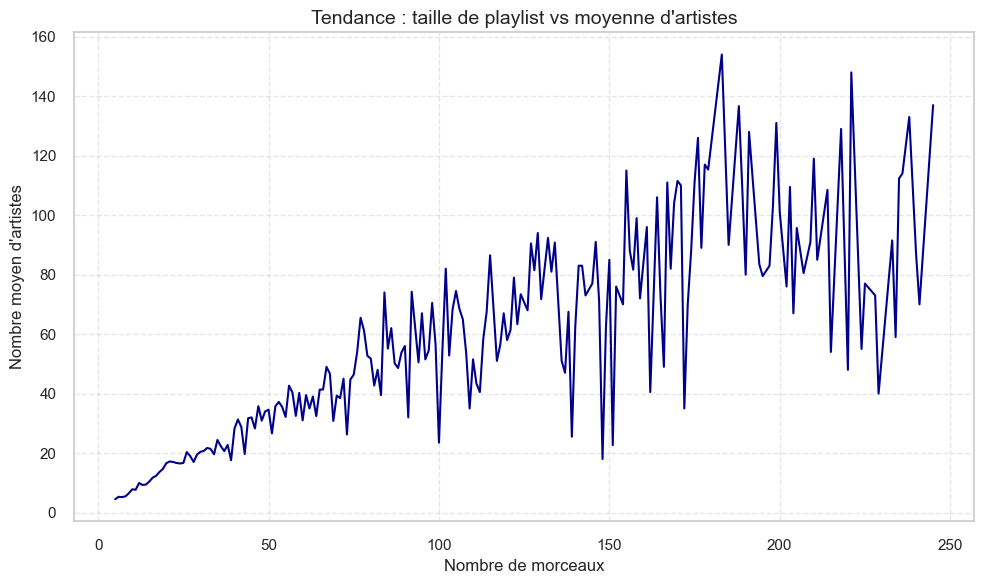

In [105]:
cleaned_data_path = os.path.join(base_dir, 'alcrowd', 'alcrowd_cleaned.csv')
df = pd.read_csv(cleaned_data_path, encoding="latin1", sep=None, engine="python")

df_unique = df.drop_duplicates(subset="pid")

df_unique["taille_classe"] = pd.cut(
    df_unique["num_tracks"],
    bins=[0, 50, 100, 150, 200, 1000],
    labels=["0-50", "51-100", "101-150", "151-200", "200+"]
)

sns.set(style="whitegrid")

plt.figure(figsize=(10, 6))
sns.regplot(data=df_unique, x="num_tracks", y="num_artists", scatter_kws={"alpha": 0.2}, line_kws={"color": "red"})
plt.title("Nombre de morceaux vs nombre d'artistes", fontsize=14)
plt.xlabel("Nombre de morceaux")
plt.ylabel("Nombre d'artistes")
plt.tight_layout()
plt.show()

moyennes_par_taille = df_unique.groupby("num_tracks")["num_artists"].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.lineplot(data=moyennes_par_taille, x="num_tracks", y="num_artists", color="darkblue")
plt.title("Tendance : taille de playlist vs moyenne d'artistes", fontsize=14)
plt.xlabel("Nombre de morceaux")
plt.ylabel("Nombre moyen d'artistes")
plt.grid(True, linestyle="--", alpha=0.5)
plt.tight_layout()
plt.show()

#### Hypothèse 4 : Plus d'artistes = Plus de followers

In [106]:
df = pd.read_csv(cleaned_data_path, encoding="latin1", sep=None, engine="python")
df = df[['name', 'num_followers', 'num_artists']].drop_duplicates()

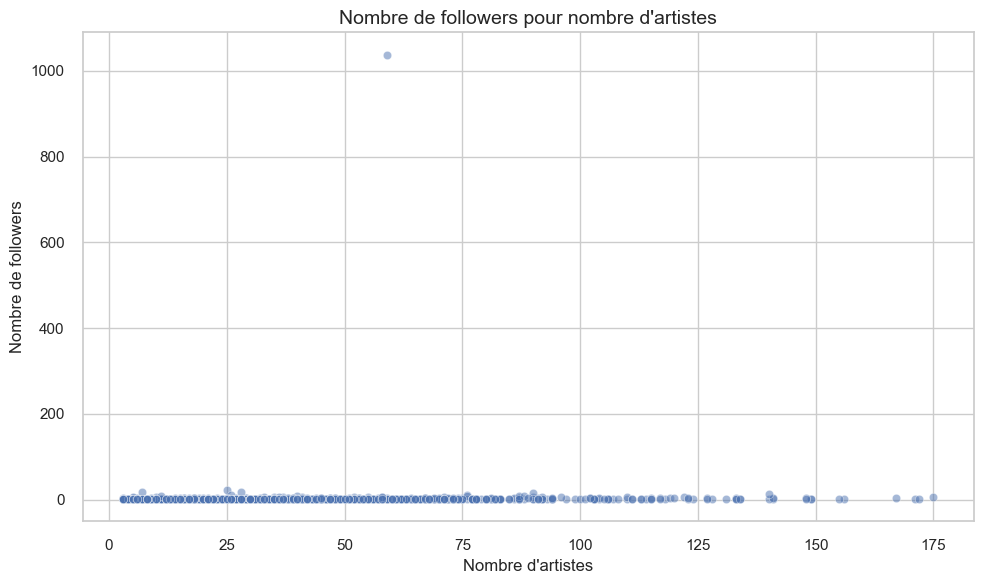

In [107]:
def plot_followers_vs_artists(df):
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='num_artists', y='num_followers', alpha=0.5)
    plt.title("Nombre de followers pour nombre d'artistes", fontsize=14)
    plt.xlabel("Nombre d'artistes")
    plt.ylabel("Nombre de followers")
    plt.tight_layout()
    plt.show()
    
plot_followers_vs_artists(df)

In [108]:
df.describe()

,num_followers,num_artists
count,1000.000000,1000.000000
mean,2.583000,38.746000
std,32.813501,31.245091
min,1.000000,3.000000
25%,1.000000,16.000000
50%,1.000000,30.000000
75%,1.250000,53.000000
max,1038.000000,175.000000


Le graphique et les statistiques montrent que la tendance de la grande partie des playlist est qu'elles sont créés par le meme utilisateur pour ses propres besoins.

La realité "collaborative et de partage" est donc une très petite realité en comparaison aux playlist créés.


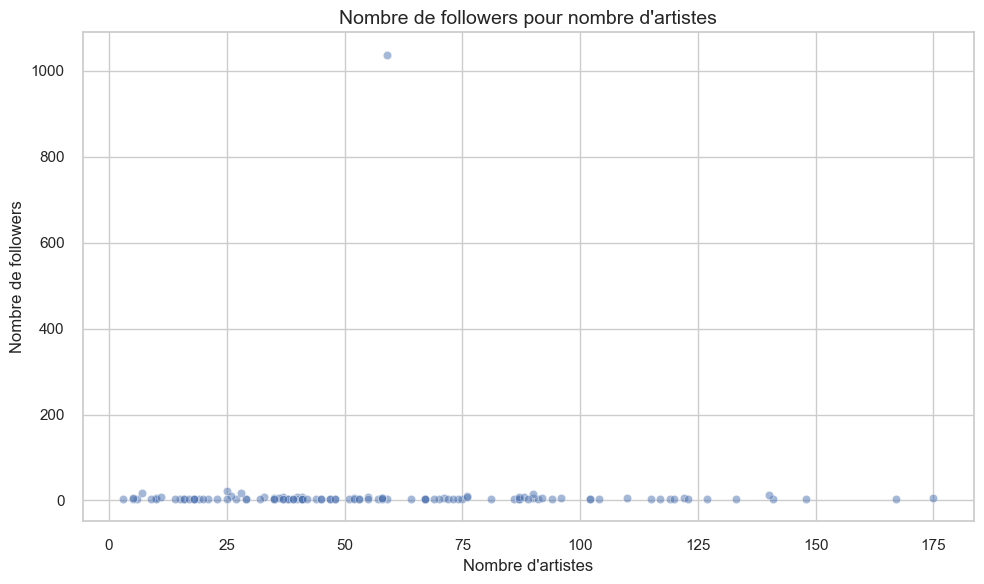

In [109]:
df_plus_followers = df[df['num_followers'] > 2]

plot_followers_vs_artists(df_plus_followers)

Meme en regardant les cas où il y a plus de 1 follower, nous avons aucune relation entre le nombre d'artistes et le nombre de followers, donc l'hypothèse n'est pas confirmée